# Project: Data Wrangling (WeRateDog twitter data)

## Table of contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gather</a></li>
<li><a href="#access">Access</a></li>
<li><a href="#clean">Clean</a></li>
<li><a href="#eda">Analysing and Visualization of data</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id="intro"></a>
## Introduction

WeRateDogs is a twitter account which share dog images and write a brief panegyric about the dog, then they let their followers to rate it by favoriting it. By asking WeRateDogs to share with us some of their tweets, they did. They have shared 5000+ of their tweets which contains some basic data. Sometimes in their brief panegyric they mention the breed of the dog, and some others they don’t. But thanks to Udacity, they have performed some neutral network procedures to classify the dogs based on their images which are shared with the tweets.

<a id="gather"></a>

# Gather

In [1]:
#Import required libraries:

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
import json
import os
import re
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline
import random
from pandas import *

#### Image prediction .tsv file

In [ ]:
#Download the image prediction .tsv file programmatically

folder_name = 'image_prediction'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(os.path.join(folder_name,url.split('/')[-1]),mode='wb') as file:
    file.write(response.content)

In [2]:
image_prediction = pd.read_csv('image_prediction/image-predictions.tsv', sep='\t')

#### twitter api .json file

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
consumer_key = 'API KEY'
consumer_secret = 'API SECRET'
access_token = 'ACCESS TOKEN'
access_secret = 'ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)
#api = tweepy.API(auth)




tweet_ids = twitter_archived_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except Exception as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

- The above code would generate the data from twitters API using tweepy

In [3]:
#Read tweet_json.txt file, line by line, and create a list of dictionaries:

twitter_api = []
with open ('tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        
        twitter_api.append({'tweet_id' : tweet_id,
                         'retweet_count' : retweet_count,
                         'favorite_count':favorite_count})

In [4]:
#Read the .json file in twitter_api dataframe:
twitter_api_df = pd.DataFrame(twitter_api)

- The above code read the tweet_id, retweet_count and favourite_count in a dataframe

#### twitter archived enhanced .csv file

In [5]:
#Read the .csv file in dataframe twitter_archive_enhanced:

twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

<a id="access"></a>

# Access

### Visual assessment

In [6]:
#Taking a view of the image_prediction table

image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


- We can see that the above dataset has 2075 rows and 12 columns
- Also there are columns that are not descriptive

In [7]:
#Taking a view of the twitter_api_df table

twitter_api_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [8]:
#Taking a view of the twitter_archive_enhanced table

twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


- Notice that the `doggo`, `floofer`, `pupper` and `puppo` columns has majority None inputs which are meant to be NaN

### Programmatic assessment

In [9]:
#Taking a view of the image_prediction summary

image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- Notice that the tweet_id is an int rather than string datatype

In [10]:
#Taking a view of the image_prediction summary statistics

image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [11]:
#Checking for duplicated values

image_prediction.duplicated().sum()

0

- It shows that there are no duplicated values in the `image_prediction` table

In [12]:
#Checking the summary of twitter_api_df dataframe

twitter_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [13]:
#Checking the summary statistics for the twitter_api_df dataframe

twitter_api_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [14]:
#checking for duplicates in the twitter_api_df dataframe

twitter_api_df.duplicated().sum()

0

In [15]:
#Taking a view of twitter_archive_enhanced dataframe summary

twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
#Taking a view of the twitter_archive_enhanced dataframe summary statistics

twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
twitter_archive_enhanced['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
twitter_archive_enhanced.duplicated().sum()

0

In [19]:
#checking the unique values in the dog stages columns
stages = ['doggo', 'floofer', 'pupper', 'puppo']

for i in stages:
    print('Unique values in ', i , ' are:', twitter_archive_enhanced[i].unique())

Unique values in  doggo  are: ['None' 'doggo']
Unique values in  floofer  are: ['None' 'floofer']
Unique values in  pupper  are: ['None' 'pupper']
Unique values in  puppo  are: ['None' 'puppo']


In [20]:
#checking the total number of unique values

twitter_archive_enhanced['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [21]:
#actual number of tweets only

(twitter_archive_enhanced['tweet_id'].count())- (twitter_archive_enhanced['in_reply_to_status_id'].count() + twitter_archive_enhanced['retweeted_status_id'].count())

2097

In [22]:
#checking the values for dog name in the twitter_archive_enhanced table

twitter_archive_enhanced['name'].value_counts()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Skittle      1
Linus        1
Bobb         1
Dido         1
Rudy         1
Name: name, Length: 957, dtype: int64

In [23]:
twitter_archive_enhanced.timestamp.head(6)

0    2017-08-01 16:23:56 +0000
1    2017-08-01 00:17:27 +0000
2    2017-07-31 00:18:03 +0000
3    2017-07-30 15:58:51 +0000
4    2017-07-29 16:00:24 +0000
5    2017-07-29 00:08:17 +0000
Name: timestamp, dtype: object

## Quality

#### `image_prediction` table
- tweet_id is an int not string also in `twitter_api_df`, and `twitter_archive_enhanced` table


#### `twitter_api_df` table
- Non descriptive headers ('p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog' )


#### `twitter_archive_enhanced` table
- dog name different from original name in text column sometimes
- timestamp is an object not datetime datatype
- Null values filled with None in 'doggo', 'floofer', 'pupper', and 'puppo' columns
- tweet source not in right format
- Incorrect dog rating sometimes, rating_denominators not in multiples of 10 sometimes
- irrelevants records of tweets ( 2356 instead of 2097)


### Tidiness

- One variable(dog stage) in four columns(doggo, floofer, pupper, puppo)
- Tweet link in text column for twitter_archive_enhanced dataset
- The three datasets should be merged on tweet_id

<a id="clean"></a>

# Clean

In [24]:
# create a copy for each datasets

image_clean = image_prediction.copy()
tweet_api_clean = twitter_api_df.copy()
tweet_archive_clean = twitter_archive_enhanced.copy()

### tweet_id is an int not a string

#### Define

Change the tweet_id datatypes in `image_prediction`, `twitter_api`, and` twitter_archive` table to a string

#### Code

In [25]:
df_list = [image_clean,tweet_api_clean,tweet_archive_clean]

for table in df_list:
    table.tweet_id = table.tweet_id.astype(str)

#### Test

In [26]:
image_clean['tweet_id'].dtype

dtype('O')

In [27]:
tweet_api_clean['tweet_id'].dtype

dtype('O')

In [28]:
tweet_archive_clean['tweet_id'].dtype

dtype('O')

### Non descriptive headers ('p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog' )

#### Define

Rename the columns to a more relatable name say: `p1 to dog_1, p1_conf to conf_1, p1_dog to result_1, p2 to dog_2, p2_conf to conf_2` and so on

#### Code

In [29]:
#Rename the 9 columns
image_clean = image_clean.rename(columns={'p1':'dog_1', 'p1_conf':'conf_1', 'p1_dog':'result_1', 
                                        'p2':'dog_2', 'p2_conf':'conf_2', 'p2_dog':'result_2', 
                                        'p3':'dog_3', 'p3_conf':'conf_3', 'p3_dog':'result_3'})

#### Test

In [30]:
image_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'dog_1', 'conf_1', 'result_1',
       'dog_2', 'conf_2', 'result_2', 'dog_3', 'conf_3', 'result_3'],
      dtype='object')

### dog name different from original name in text column sometimes

#### Define

- The name of dogs in the text columns of the `twitter_archive_enhanced` table did not match the names on the name column sometimes. 
- We would have to make use of regular expression to extract the original name from the text column and store it in a new column
- We drop the name column afterwards

#### Code

In [31]:
list(tweet_archive_clean.text.sample(10))

["RT @dog_rates: When she says you're a good boy and you know you're a good boy because you're a good boy. 13/10 https://t.co/O5IUmRHRIh",
 "This is Malcolm. He's absolutely terrified of heights. 8/10 hang in there pupper https://t.co/SVU00Sc9U2",
 'Here we see 33 dogs posing for a picture. All get 11/10 for superb cooperation https://t.co/TRAri5iHzd',
 "This is Koda. She's a Beneboom Cumberwiggle. 12/10 petable as hell https://t.co/VZV6oMJmU6",
 "Unfamiliar with this breed. Ears pointy af. Won't let go of seashell. Won't eat kibble. Not very fast. Bad dog 2/10 https://t.co/EIn5kElY1S",
 "This is Hobbes. He's never seen bubbles before. 13/10 deep breaths buddy https://t.co/QFRlbZw4Z1",
 "Say hello to Nala. She's a Freckled High Bruschetta. Petable af. 12/10 https://t.co/5bjrIRqByp",
 "Meet Max. He's a Fallopian Cephalopuff. Eyes are magical af. Lil dandruff problem. No big deal 10/10 would still pet https://t.co/c67nUjwmFs",
 'Like doggo, like pupper version 2. Both 11/10 https://t.co/

In [32]:
#Extract dog_name from text
tweet_archive_clean['dog_name'] = tweet_archive_clean.text.str.extract(
    "((?<= named )[A-Z][a-z]+| (?<= [i,']s )[A-Z][a-z]+| (?<=[M,m]eet )[A-Z][a-z]+| (?<= to )[A-Z][a-z]+)", expand = True)

#### Test

In [33]:
tweet_archive_clean[['dog_name','name']].sample(15)

,dog_name,name
1648,Buddy,Buddy
1211,Bertson,Bertson
1945,Raymond,Raymond
1451,Wyatt,Wyatt
1614,Petrick,Petrick
2135,Liam,Liam
660,Mabel,Mabel
1406,Charl,Charl
1300,Jiminus,Jiminus
332,NaN,None


In [34]:
#Let's Check the new real dog names count after extraction from text column
tweet_archive_clean.dog_name.str.istitle().sum() - tweet_archive_clean.query('dog_name == "None"').count()[0]

1541

In [35]:
#Let's check the number of correct names in name column to evaluate our result
tweet_archive_clean.name.str.istitle().sum() - tweet_archive_clean.query('name == "None"').count()[0]

1496

In [36]:
tweet_archive_clean.dog_name.value_counts().sum()

1541

#### Define

- To avoid multiple column with same data, we drop the name column

#### Code

In [37]:
#Drop the `name` column
tweet_archive_clean = tweet_archive_clean.drop(['name'], axis = 1)

#### test

In [38]:
tweet_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo',
       'dog_name'],
      dtype='object')

### Timestamp is an object not datetime datatype

#### Define

- Change the timestamp column from an object datatype to a datetime datatype after slicing

#### Code

In [39]:
#Cut the last 6 characters from datetime to fit our pattern
tweet_archive_clean['timestamp'] = tweet_archive_clean['timestamp'].astype('str').str[:-6]
tweet_archive_clean['timestamp'] = pd.to_datetime(tweet_archive_clean['timestamp'], format = '%Y-%m-%d %H:%M:%S')

#### Test

In [40]:
tweet_archive_clean.timestamp.dtype

dtype('<M8[ns]')

In [41]:
tweet_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

### Null values filled with None in 'doggo', 'floofer', 'pupper', and 'puppo' columns

#### Define

Null values were filled with None instead of the numpy null object. We therefore have to replacet the None with np.nan

#### Code

In [42]:
dog_stage = ['doggo', 'floofer', 'pupper','puppo']

for stages in dog_stage:
    tweet_archive_clean[stages].replace('None', np.nan, inplace=True)

#### Test

In [43]:
tweet_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

### Incorrect dog rating sometimes

#### Define

Remove invalid ratings creating a function to extract ratings, both decimal and non decimal. It only extracts ratings with denominator of 10 and it also extracts negative ratings. Some of the tweets in the dataset have more than one dog rating so extract only last

#### Code

In [44]:
def extract_rating(text):
    try:
        return re.findall("-?\d+\.\d+\/10|-?\d+\/10", text)[-1]
    except IndexError:
        return np.nan

In [45]:
# Function to split the rating numbers to fill the numerator and denominator columns in the dataset
def split_rating(rating, index):
    try:
        return rating.split("/")[index]
    except AttributeError:
        return 0

In [46]:
# Extracting the ratings with the new regular expression and storing in a new column
tweet_archive_clean['rating'] = tweet_archive_clean['text'].apply(
    lambda x: extract_rating(x))

# Confirming changes
tweet_archive_clean[['text', 'rating_numerator',
                         'rating_denominator', 'rating']]

,text,rating_numerator,rating_denominator,rating
0,This is Phineas. He's a mystical boy. Only eve...,13,10,13/10
1,This is Tilly. She's just checking pup on you....,13,10,13/10
2,This is Archie. He is a rare Norwegian Pouncin...,12,10,12/10
3,This is Darla. She commenced a snooze mid meal...,13,10,13/10
4,This is Franklin. He would like you to stop ca...,12,10,12/10
...,...,...,...,...
2351,Here we have a 1949 1st generation vulpix. Enj...,5,10,5/10
2352,This is a purebred Piers Morgan. Loves to Netf...,6,10,6/10
2353,Here is a very happy pup. Big fan of well-main...,9,10,9/10
2354,This is a western brown Mitsubishi terrier. Up...,7,10,7/10


In [47]:
# Extracting the numerators and denominators again
tweet_archive_clean['rating_numerator'] = tweet_archive_clean['rating'].apply(
    lambda x: split_rating(x, 0))
tweet_archive_clean['rating_denominator'] = tweet_archive_clean['rating'].apply(
    lambda x: split_rating(x, 1))

# Confirming changes made
tweet_archive_clean[['text', 'rating_numerator',
                         'rating_denominator', 'rating']]

,text,rating_numerator,rating_denominator,rating
0,This is Phineas. He's a mystical boy. Only eve...,13,10,13/10
1,This is Tilly. She's just checking pup on you....,13,10,13/10
2,This is Archie. He is a rare Norwegian Pouncin...,12,10,12/10
3,This is Darla. She commenced a snooze mid meal...,13,10,13/10
4,This is Franklin. He would like you to stop ca...,12,10,12/10
...,...,...,...,...
2351,Here we have a 1949 1st generation vulpix. Enj...,5,10,5/10
2352,This is a purebred Piers Morgan. Loves to Netf...,6,10,6/10
2353,Here is a very happy pup. Big fan of well-main...,9,10,9/10
2354,This is a western brown Mitsubishi terrier. Up...,7,10,7/10


In [48]:
# Changing the datatype to float and int respectively
tweet_archive_clean = tweet_archive_clean.astype(
    {'rating_numerator': 'float64'})

In [49]:
tweet_archive_clean['rating_denominator'] = tweet_archive_clean['rating_denominator'].astype(
    int)

#### Test

In [50]:
tweet_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,dog_name,rating
1843,675853064436391936,NaN,NaN,2015-12-13 01:41:41,"<a href=""http://twitter.com/download/iphone"" r...",Here we have an entire platoon of puppers. Tot...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675853064...,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1241,712065007010385924,NaN,NaN,2016-03-21 23:55:01,"<a href=""http://twitter.com/download/iphone"" r...",This is Chester. He's clearly in charge of the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712065007...,6.0,10,NaN,NaN,NaN,NaN,Chester,6/10
2066,671147085991960577,NaN,NaN,2015-11-30 02:01:49,"<a href=""http://twitter.com/download/iphone"" r...",This is a Helvetica Listerine named Rufus. Thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085...,9.0,10,NaN,NaN,NaN,NaN,Rufus,9/10
2202,668643542311546881,NaN,NaN,2015-11-23 04:13:37,"<a href=""http://twitter.com/download/iphone"" r...",Fascinating dog here. Loves beach. Oddly long ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668643542...,3.0,10,NaN,NaN,NaN,NaN,NaN,3/10
908,757729163776290825,NaN,NaN,2016-07-26 00:08:05,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Chompsky. He lives up t...,6.790626e+17,4.196984e+09,2015-12-21 22:15:18 +0000,https://twitter.com/dog_rates/status/679062614...,11.0,10,NaN,NaN,NaN,NaN,Chompsky,11/10


In [51]:
tweet_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   float64       
 11  rating_denominator          2356 non-null   int32       

In [52]:
tweet_archive_clean['rating_numerator'].value_counts()

 12.00      557
 11.00      466
 10.00      454
 13.00      355
 9.00       156
 8.00       104
 14.00       56
 7.00        56
 6.00        33
 5.00        33
 3.00        19
 0.00        18
 4.00        16
 2.00        10
 1.00         9
 15.00        2
 420.00       2
 9.75         2
 1776.00      1
 9.50         1
-5.00         1
 11.26        1
 11.27        1
 13.50        1
 666.00       1
 182.00       1
Name: rating_numerator, dtype: int64

- Observe that there is a rating of -5, it is a void entry, but we can't deduce why.
- checking the row of the dataset might give a clue

In [53]:
tweet_archive_clean[tweet_archive_clean['rating_numerator'] == -5.00]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,dog_name,rating
2260,667550882905632768,NaN,NaN,2015-11-20 03:51:47,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Unoriginal idea. Blatant ...,6.675484e+17,4.296832e+09,2015-11-20 03:41:59 +0000,https://twitter.com/dogratingrating/status/667...,-5.0,10,NaN,NaN,NaN,NaN,NaN,-5/10


### tweet source not in right format

#### Define

source of tweets are embedded in HTML tags. We therefore use regular expression to extract the source

#### Code

In [54]:
#Using regex to extract the source 
tweet_archive_clean['source'] = tweet_archive_clean['source'].str.extract(r"(?<=>)(.*)(?=<)")

#### Test

In [55]:
tweet_archive_clean.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Irrelevants records of tweets ( 2356 instead of 2097)

#### Define
We need to drop in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id & retweeted_status_timestamp after filtering them to only tweets and keep only NaN values in twitter_archive_enhanced

#### Code

In [56]:
#Create a loop to filter for NaN values and then drop the columns
list = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
        'retweeted_status_user_id', 'retweeted_status_timestamp']

for cols in list:
    tweet_archive_clean = tweet_archive_clean[tweet_archive_clean[cols].isnull()]
    tweet_archive_clean = tweet_archive_clean.drop([cols], axis = 1)

#### Test

In [57]:
#Check for drop columns
tweet_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'pupper',
       'puppo', 'dog_name', 'rating'],
      dtype='object')

In [58]:
#Make sure that we have only 2097 rows
tweet_archive_clean.shape[0]

2097

#### Define
- keep only tweets with images and drop NaN values in the `expanded_urls` columns

#### Code

In [59]:
#Use notna to keep only the tweets with photos 
tweet_archive_clean = tweet_archive_clean[tweet_archive_clean['expanded_urls'].notna()]

#### Test

In [60]:
tweet_archive_clean['expanded_urls'].isnull().sum()

0

### One variable(dog stage) in four columns(doggo, floofer, pupper, puppo)

#### Define

The dog stages should be in one column, hence no need for multiple stage columns. We drop the `'doggo', 'puppo', 'pupper', 'floofer'` columns afterwards

#### Code1

In [61]:
#Create a list for the stage columns
dog_stages = ['doggo', 'puppo', 'pupper', 'floofer']

#Create a loop to replace the NaN in the 4 columns with space ''
for stage in dog_stages:
    tweet_archive_clean[stage] = tweet_archive_clean[stage].replace(np.nan,'')

In [62]:
#Create a new column for the dog stages and fill it with the data in the 4 columns

tweet_archive_clean['stage'] = tweet_archive_clean['doggo'] + tweet_archive_clean['puppo'] + tweet_archive_clean['pupper'] + tweet_archive_clean['floofer']

#### Test1

In [63]:
#Check the new stage values 
tweet_archive_clean['stage'].value_counts()

                1759
pupper           220
doggo             72
puppo             23
doggopupper        9
floofer            9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

- We could see that some dogs have two stages, hence let's separate them with the underscore character to have a better look

#### Code2

In [64]:
#Add a "_" between the two stages in one cell
tweet_archive_clean['stage'] = tweet_archive_clean['stage'].replace('doggopupper','doggo_pupper')
tweet_archive_clean['stage'] = tweet_archive_clean['stage'].replace('doggopuppo','doggo_puppo')
tweet_archive_clean['stage'] = tweet_archive_clean['stage'].replace('doggofloofer','doggo_floofer')

#### Test2

In [65]:
tweet_archive_clean['stage'].value_counts()

                 1759
pupper            220
doggo              72
puppo              23
doggo_pupper        9
floofer             9
doggo_puppo         1
doggo_floofer       1
Name: stage, dtype: int64

#### Code3

In [66]:
#Drop the 4 columns ['doggo', 'puppo', 'pupper', 'floofer'] from the tweet_archive_clean table
tweet_archive_clean = tweet_archive_clean.drop(['doggo', 'puppo', 'pupper', 'floofer'], axis = 1)

#### Test3

In [67]:
#Check the new columns of archive_copy
tweet_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'dog_name', 'rating',
       'stage'],
      dtype='object')

### Tweet link in text column for twitter_archive_enhanced dataset

#### Define

Tweet link should be separated from the text column for easy access using regular expression and stored in a separate column

#### Code

In [68]:
#Taking a view of some the tweet link to know how to define our regex pattern

dict(tweet_archive_clean['text'].sample(7))

{883: 'This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP',
 66: 'This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY',
 1248: '"Please, no puparazzi" 11/10 https://t.co/nJIXSPfedK',
 1771: 'This is Rosie. She has a snazzy bow tie and a fin for a tail. Probably super fast underwater. Cool socks 10/10 https://t.co/GO76MdGBs0',
 550: 'This is Django. He accidentally opened the front facing camera. Did him quite the frighten. 12/10 https://t.co/kQVQoOW9NZ',
 2185: "This is Ruby. She's a Bimmington Fettuccini. One ear works a lil better than other. Looks startled. Cool carpet 9/10 https://t.co/j0Wpa42KCH",
 2250: "THE EYES 12/10\n\nI'm sorry. These are supposed to be funny but your dogs are too adorable https://t.co/z1xPTgVLc7"}

In [69]:
#Create a new column and Use regex to extract tweet's link from text
tweet_archive_clean['tweet_link'] = tweet_archive_clean['text'].str.extract("(https://t.co/[a-zA-Z0-9-]+)", expand = True)

#### Test

In [70]:
tweet_archive_clean['tweet_link'].sample(7)

1052    https://t.co/UHvjxm9B0O
2172    https://t.co/6WGFp9cuj6
2059    https://t.co/96tMaWyoWt
15      https://t.co/WpHvrQedPb
348     https://t.co/u6p4LxzHKg
370     https://t.co/ZH5CvRlCxt
1776    https://t.co/4JS92YAxTi
Name: tweet_link, dtype: object

### The three datasets should be merged on tweet_id

#### Define

- The three dataset `twitter_archive_enhanced`, `twitter_api_df` and `image_prediction` should be merged on tweet_id

#### Code

In [71]:
#Merge twitter_archive_enhanced & image_predictions on tweet_id
archive_image = pd.merge(tweet_archive_clean, image_clean, on='tweet_id')

In [72]:
#Merge archive_image & twitter_api on tweet_id
twitter_archive_master = pd.merge(archive_image, tweet_api_clean, on='tweet_id')

In [74]:
#Make sure that our new dataframe matches our cleaning steps
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   float64       
 6   rating_denominator  1971 non-null   int32         
 7   dog_name            1381 non-null   object        
 8   rating              1959 non-null   object        
 9   stage               1971 non-null   object        
 10  tweet_link          1971 non-null   object        
 11  jpg_url             1971 non-null   object        
 12  img_num             1971 non-null   int64         
 13  dog_1               1971 non-null   object      

#### Test

In [75]:
twitter_archive_master.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,rating,stage,...,conf_1,result_1,dog_2,conf_2,result_2,dog_3,conf_3,result_3,retweet_count,favorite_count
297,824775126675836928,2017-01-27 00:24:48,Twitter for iPhone,This is Scooter. His lack of opposable thumbs ...,https://twitter.com/dog_rates/status/824775126...,12.0,10,Scooter,12/10,,...,0.610499,True,malinois,0.090291,True,Airedale,0.068625,True,4069,16508
1058,702671118226825216,2016-02-25 01:47:04,Twitter for iPhone,Meet Rambo &amp; Kiwi. Rambo's the pup with th...,https://twitter.com/dog_rates/status/702671118...,10.0,10,Rambo,10/10,,...,0.381227,True,Sussex_spaniel,0.212017,True,clumber,0.128622,True,634,2398
1630,672267570918129665,2015-12-03 04:14:13,Twitter for iPhone,When you accidentally open up the front facing...,https://twitter.com/dog_rates/status/672267570...,10.0,10,NaN,10/10,,...,0.716932,True,miniature_pinscher,0.051234,True,Airedale,0.044381,True,666,1588


### Storing the dataset

#### Define

- store the cleaned dataset in a csv format named `twitter_archive_master`

#### Code

In [76]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

#### Test

In [77]:
tweet_df = pd.read_csv('twitter_archive_master.csv')
tweet_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,rating,stage,...,conf_1,result_1,dog_2,conf_2,result_2,dog_3,conf_3,result_3,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,13/10,NaN,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,13/10,NaN,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,12/10,NaN,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,13/10,NaN,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,12/10,NaN,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048


In [78]:
#double checking if our cleaning process was effective
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   expanded_urls       1971 non-null   object 
 5   rating_numerator    1971 non-null   float64
 6   rating_denominator  1971 non-null   int64  
 7   dog_name            1381 non-null   object 
 8   rating              1959 non-null   object 
 9   stage               303 non-null    object 
 10  tweet_link          1971 non-null   object 
 11  jpg_url             1971 non-null   object 
 12  img_num             1971 non-null   int64  
 13  dog_1               1971 non-null   object 
 14  conf_1              1971 non-null   float64
 15  result_1            1971 non-null   bool   
 16  dog_2 

- It could be observed that the datatype for the tweet_id and the timestamp have been changed back
- we might bother changing the timestamp into a datetime object

<a id="eda"></a>

## Analyzing and Visualization of the Dataset

In [79]:
#checking the summary statistics of the dataset

tweet_df.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,conf_1,conf_2,conf_3,retweet_count,favorite_count
count,1.971000e+03,1971.000000,1971.000000,1971.000000,1971.000000,1.971000e+03,1.971000e+03,1971.000000,1971.000000
mean,7.360418e+17,11.569143,9.939117,1.201928,0.594558,1.345850e-01,6.016556e-02,2784.449518,8949.106545
std,6.752810e+16,40.886170,0.778093,0.559020,0.272126,1.010527e-01,5.094156e-02,4697.662893,12267.799790
min,6.660209e+17,0.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,16.000000,81.000000
25%,6.758656e+17,10.000000,10.000000,1.000000,0.363091,5.339800e-02,1.608055e-02,628.500000,1997.000000
50%,7.088343e+17,11.000000,10.000000,1.000000,0.587764,1.173970e-01,4.944380e-02,1367.000000,4147.000000
75%,7.880951e+17,12.000000,10.000000,1.000000,0.847827,1.955655e-01,9.153815e-02,3239.000000,11402.500000
max,8.924206e+17,1776.000000,10.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,79515.000000,132810.000000


- we could notice that there was a dog rating of 0
- Most of the images in the tweets were one
- The minimum retweet_count was 16
- There is a confidence value of 100, which could mean that the picture was a specific breed of dog and from a p1 algorithm

#### Which twitter source was used mostly in making tweets by followers of #WeRateDogs?

In [80]:
tweet_df['source'].value_counts()

Twitter for iPhone    1932
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

- It is evident that most of their follower uses iPhone, as the `twitter for iphone` source has the highest count of 1932

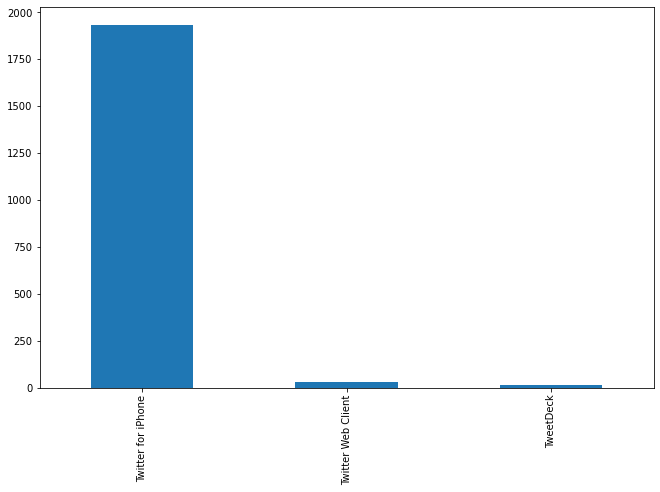

In [87]:
#Let's visualize our result
rcParams['figure.figsize'] = 11, 7

tweet_df['source'].value_counts().plot(kind='bar')

plt.savefig('bar.jpg')

#### Is there any correlation between our numerical values?

In [88]:
tweet_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'dog_name', 'rating', 'stage',
       'tweet_link', 'jpg_url', 'img_num', 'dog_1', 'conf_1', 'result_1',
       'dog_2', 'conf_2', 'result_2', 'dog_3', 'conf_3', 'result_3',
       'retweet_count', 'favorite_count'],
      dtype='object')

In [89]:
#storing the numerical values separately in a variable
tweet_numerical = tweet_df[['img_num', 'dog_1', 'conf_1', 'result_1',
       'dog_2', 'conf_2', 'result_2', 'dog_3', 'conf_3', 'result_3',
       'retweet_count', 'favorite_count']]

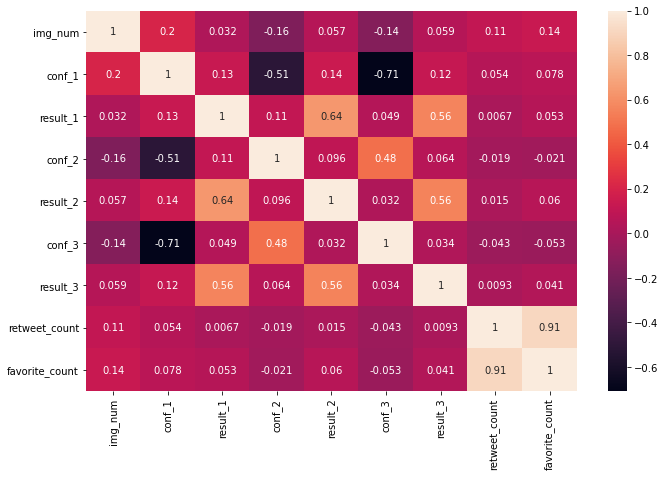

In [90]:
#Plot a heatmap to show the correlation between the numeric variables
sns.heatmap(tweet_numerical.corr(), annot = True);

plt.savefig('heatmap.jpg')

- We could see that there was a strong positive correlation of 0.91(91%) between `favorite_count` and `retweet_count`
- There is a strong negative correlation between conf_1 and conf_3

#### we might want to plot a scatter plot to ascertain our claim on the correlation

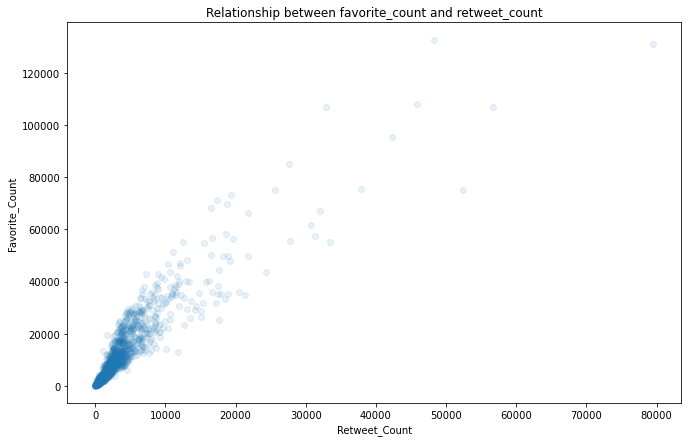

In [91]:
#Let's plot a scatter diagram showing the relationship between the retweets_count and favorite_count values
plt.scatter(data=tweet_df, x='retweet_count', y='favorite_count', alpha = 0.1);

#Titles and labels
plt.xlabel('Retweet_Count')
plt.ylabel('Favorite_Count')
plt.title('Relationship between favorite_count and retweet_count')

plt.savefig('correlation.jpg')

### What are the top dog_stages present?

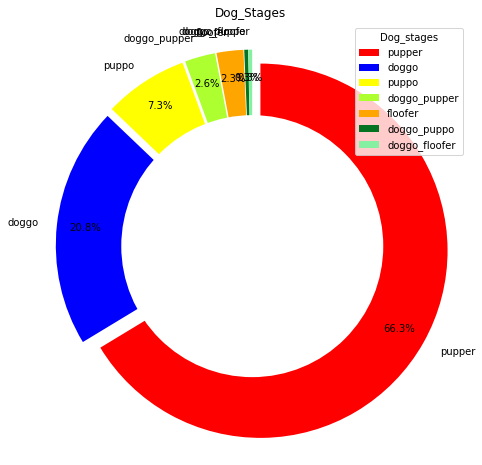

<Figure size 864x576 with 0 Axes>

In [94]:
#setting the figure size


# Setting labels for items in Chart
dog_stage = tweet_df.stage.value_counts()[:7]
rcParams['figure.figsize'] = 12, 8

# colors
colors = ['#FF0000', '#0000FF', '#FFFF00','#ADFF2F', '#FFA500', '#057322', '#86f0a2']
# explosion
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

# Pie Chart
plt.pie(dog_stage, colors = colors, labels=dog_stage.index, autopct='%1.1f%%', startangle=90,
         pctdistance=0.85, explode = explode, counterclock = False, labeldistance=1.1)
plt.axis('square');
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('Dog_Stages')

# Add Legends
plt.legend(dog_stage.index, loc="upper right", title="Dog_stages")

# Displaying Chart
plt.show()

plt.savefig('donut.jpg')

- Pupper stage has the highest dog with 66.3%
- doggo stage dog was the second highest with 20.8%

<a id="conclusions"></a>

### Conclusion

- We have conf. = 100%, it must be clear picture for a specific breed of dog.
- Some dogs got 0 rating
- Most of tweets have only one image.
- There is a strong positive correlation between the retweets count & favorite count.
- Twitter for iPhone is the most used application for Twitter followers of WeRateDogs.
- doggo_puppo and doggo_floofer multistage have same percentage of dogs (i.e 0.3%)
- Pupper & Doggo stages have more than 80% of the dogs.
- The `favorite_count` is always greater than the `retweet_count`
- The biggest retweet count was about 79,515 and that was in 18th, June 2016(2016-06-18).
- There is a strong negative correlation between conf_1 and conf_3

## References

- How to draw donut chart using matplotlib: https://www.geeksforgeeks.org/donut-chart-using-matplotlib-in-python/